In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class SORGP:
  def __init__(self, inducing_points, dim, device="cuda" ):
    self.M = len(inducing_points)
    self.D = dim
    self.device = device
    self.inducing_points = torch.tensor( inducing_points  )

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.D).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.D).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt)
    self.yt = torch.tensor(yt)
    N = len(xt)

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)
    self.inducing_points.to(self.device)

    self.sig2 = 1.0

    # カーネル行列を定義
    self.Kmm = self.cov( self.inducing_points, self.inducing_points )
    self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M) )
    self.Knm = self.cov( self.xt, self.inducing_points )
    self.Kmn = torch.t( self.Knm )
    self.Knn = self.cov( self.xt, self.xt )
    self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

    self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.Kmn, self.Knm) )


  def plot(self, x):
      mus, sigmas = self.predict( x.reshape(-1,1) )
      plt.plot( x, mus )
      
      y_max = mus + np.sqrt(sigmas.flatten())
      y_min = mus - np.sqrt(sigmas.flatten())

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.inducing_points.detach().numpy():
        plt.plot( p, [0.0], "kx" )
      plt.plot(self.xt, self.yt)
      plt.show()

  def predict( self, x ):
    x = torch.tensor(x)
    mus = []
    sigmas = []
    K = len(x)

    Kxm = self.cov( x.reshape(-1,1), self.inducing_points )
    Kmx = torch.t( Kxm )

    sig = torch.mm(torch.mm( Kxm, self.S ), Kmx )
    mu = 1/self.sig2 * torch.mm( torch.mm( torch.mm(Kxm, self.S ), self.Kmn), self.yt.reshape(-1,1) )
        
    return mu.detach().numpy().flatten(), sig.diag().detach().numpy().flatten()


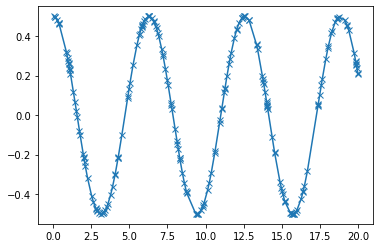

In [79]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

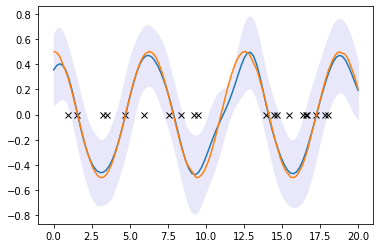

CPU times: user 176 ms, sys: 565 µs, total: 176 ms
Wall time: 181 ms


In [83]:
%%time
gp = SORGP( np.random.rand(20,1)*20 , 1, "cuda")
gp.learn( xt.reshape((-1,1)), yt )
gp.plot(np.linspace( 0,20,100 ))

In [81]:
%%time
gp.predict(np.linspace( 0,20,100 ).reshape(-1,1))

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 1.52 ms


(array([ 0.44979219,  0.44495283,  0.41968235,  0.37519742,  0.31420856,
         0.24030043,  0.1572949 ,  0.06878709, -0.02203476, -0.11229077,
        -0.19914385, -0.27953772, -0.35009903, -0.40729219, -0.44781103,
        -0.46909328, -0.46978966, -0.45002713, -0.41137234, -0.35650169,
        -0.28868298, -0.21123557, -0.12714004, -0.03891323,  0.05123221,
         0.14102972,  0.2277665 ,  0.30804265,  0.37782226,  0.43281644,
         0.46911657,  0.48389646,  0.47596512,  0.44599285,  0.39634146,
         0.33056312,  0.25274128,  0.16688909,  0.0765803 , -0.01511589,
        -0.10544942, -0.19170075, -0.27096366, -0.34012689, -0.39608284,
        -0.43608751, -0.45813082, -0.46118033, -0.44522596, -0.41114698,
        -0.36049599, -0.29531383, -0.21804761, -0.13156726, -0.03920823,
         0.05525393,  0.14775701,  0.23422351,  0.3108758 ,  0.37449828,
         0.4225806 ,  0.45334045,  0.46568352,  0.45917627,  0.43407541,
         0.39139662,  0.33295454,  0.26130095,  0.1